In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate,train_test_split
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder

C:\Users\jmbaer\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# For comparing our model scores
modelScores = {}

In [3]:
space_df = pd.read_csv('data/train.csv')
space_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Split the dataset into training and testing data
train_df, test_df = train_test_split(space_df, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df[['Transported']]
X_test, y_test = test_df.drop(columns=['Transported']), test_df[['Transported']]

In [5]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline

In [6]:
spaceTrain = pd.read_csv('data/train.csv')
spaceTest = pd.read_csv('data/test.csv')

In [7]:
spaceTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


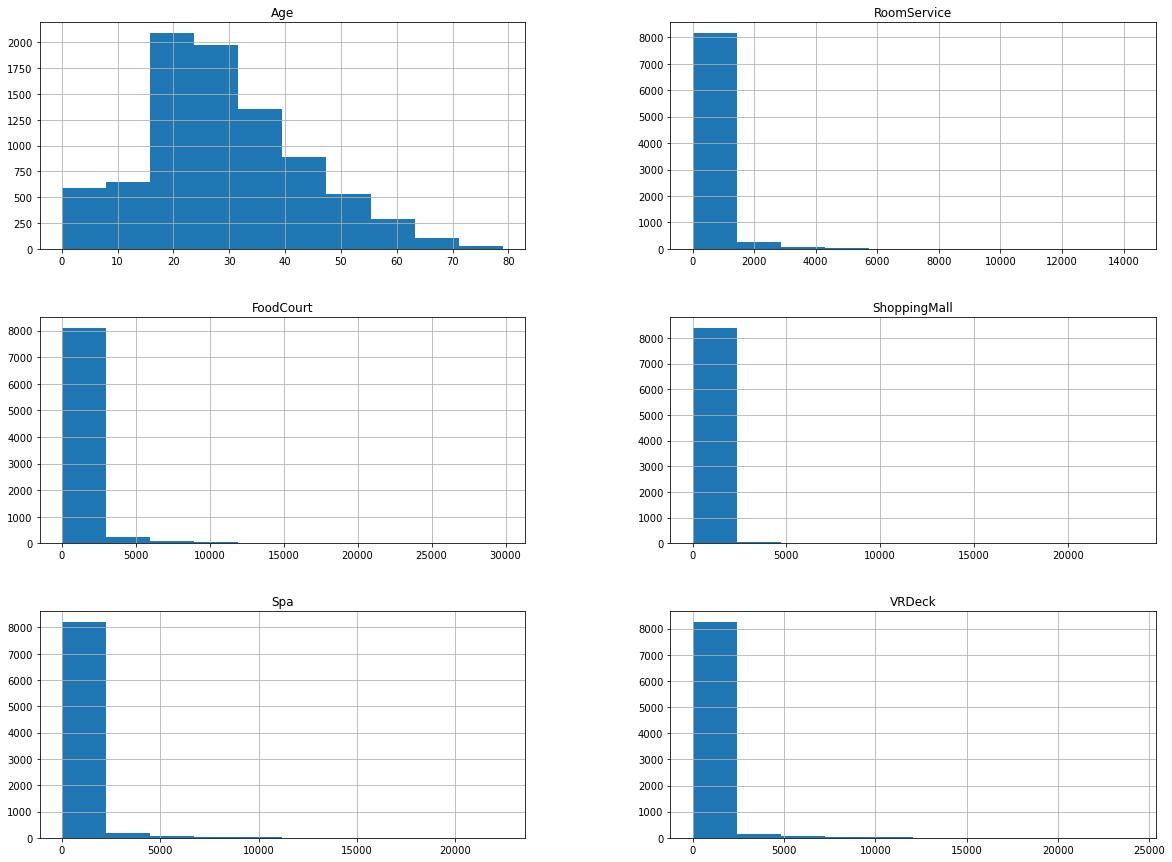

In [8]:
# Observe the distributions of our numerical features:
spaceTrain.hist(figsize=(20, 15));

In [9]:
# Let's deal with the slashes in the 'cabin' column first:
def cabinUpdate(df):
    # Split Cabin columns string on the slash and rename its columns
    cabinNew = df.Cabin.str.split('/', expand=True)
    cabinNew.columns = ['Cabin-1', 'Cabin-2', 'Cabin-3']
    # Copy the input dataframe to avoid mutating the original
    df1 = df.copy()
    # Add expanded columns to our copied dataframe:
    for col in cabinNew:
        df1[col] = cabinNew[col]
        print(cabinNew[col].value_counts())
    # Reorder the columns in the new dataframe:
    cols = df1.columns.tolist()
    cols = cols[:3] + cols[-3:] + cols[4:-3]
    df1 = df1[cols]
    return df1
# Update our DF's structure based on the Cabin column
spaceTrain = cabinUpdate(spaceTrain).copy()
# Split data into train and test
train_df, test_df = train_test_split(spaceTrain, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df['Transported']
X_test, y_test = test_df.drop(columns=['Transported']), test_df['Transported']
X_train.head()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin-1, dtype: int64
82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: Cabin-2, Length: 1817, dtype: int64
S    4288
P    4206
Name: Cabin-3, dtype: int64


,PassengerId,HomePlanet,CryoSleep,Cabin-1,Cabin-2,Cabin-3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
7074,7527_01,Earth,False,F,1561,P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley
6710,7083_01,Europa,True,C,259,S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus
2569,2755_01,Europa,True,B,85,P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy
3850,4127_01,Europa,NaN,B,130,P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle
7450,7972_02,Europa,False,B,260,P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried


In [10]:
# Define our categories of columns:
cat = ['HomePlanet',  'Cabin-1', 'Cabin-3', 'Destination']
num = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin-2']
binary = ['CryoSleep', 'VIP']
drop = ['Name']
target = 'Transported'
# Make the column transformer:
preprocessor = make_column_transformer(
        # Apply standard scaling to all our numeric features
        (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num),
        # Make a pipeline for our categorical features
        # 1. First fill NaN's with most frequent of each feature
        # 2. Then use one hot encoding on result
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat),
        # One-hot encoding of our binary column, 'sex,' so we aren't wasting space
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", dtype=int,handle_unknown='ignore')), binary),
        ('drop', drop)
)

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [12]:
spaceTest = cabinUpdate(spaceTest).copy()
X_train, y_train = spaceTrain.drop(columns=['Transported']), spaceTrain[['Transported']]

pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))

F    1445
G    1222
E     447
B     362
C     355
D     242
A      98
T       6
Name: Cabin-1, dtype: int64
4       21
31      18
197     16
294     16
228     14
        ..
1170     1
904      1
1174     1
356      1
1503     1
Name: Cabin-2, Length: 1505, dtype: int64
S    2093
P    2084
Name: Cabin-3, dtype: int64


In [13]:
pipe_catboost.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'Cabin-2']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
              

In [14]:
spaceshipPredictions = pipe_catboost.predict(spaceTest)

In [15]:
result = zip(spaceTest['PassengerId'], pd.Series(spaceshipPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./cbWithCabinResult.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2189


In [17]:
mean_std_cross_val_scores(pipe_catboost,X_train,y_train)

C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\pipeline.py", line 711, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "C:\Users\jmbaer\anaconda3\lib\site-packages\catboost\core.py", line 5446, in score
    raise CatBoost

fit_time      3.755 (+/- 0.233)
score_time    0.024 (+/- 0.005)
test_score        nan (+/- nan)
dtype: object